# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [ ]:
# load in the data
#azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';',low_memory=False)
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';',low_memory=False)

In [ ]:
customers.GEBAEUDETYP.value_counts(dropna=False)

I start from the `azdias` data, first show the summarized info:

In [ ]:
azdias.info()

In [ ]:
azdias.describe()

Display the first 5 rows:

In [ ]:
display(azdias.head())

From the first glance, there are 366 cloumns in the `azdias` dataset, which means 366 attributes, and lots of missing values (`NaN`) in each attributes. I think the first step is to fingure out what does each attribute mean.

After review the `DIAS Attributes - Values 2017.xlsx` file, I found some attributes are not well explained, such as `AKT_DAT_KL`, also some attributes has missing values which is not `NaN`, such as `-1` in `AGER_TYP`. 

So I parsed a `.csv` from `DIAS Attributes - Values 2017.xlsx`, which lists all missing values for each attribute.

In [ ]:
def summary_missing_value(inputPath, outputPath):
    # load the attrbutes values summary .xlsx file
    attributes_values = pd.read_excel(inputPath, sheet_name='Tabelle1')
    
    
    # drop first meaningless column
    attributes_values.drop(columns = ['Unnamed: 0'], inplace = True)
    
    # get all attributes names with description and value meaning:
    attributes_names = attributes_values.dropna()[['Attribute','Description','Meaning']]

    # get all attributes with unknow meaning
    attributes_values_unknown = attributes_values[attributes_values.Meaning.isin(['unknown','unknown / no main age detectable'])][['Attribute','Value']]
    
    
    # there are attributes which is special 'RELAT_AB' 'KBA05_AUTOQUOT' 'CAMEO_DEUG_2015'
    attributes_values_unknown.dropna(inplace=True)
    
    #attributes_values_unknown[attributes_values_unknown.Attribute == 'CAMEO_DEUG_2015'].Value = '-1,X'
    attributes_values_unknown.loc[len(attributes_values_unknown)] = ['RELAT_AB','-1,9']
    
    attributes_values_unknown.loc[len(attributes_values_unknown)] = ['KBA05_AUTOQUOT','-1,9']
    
    # Merge attributes_names with attributes_values_unknown
    attributes_missing_values = pd.merge(attributes_names,attributes_values_unknown,on = ['Attribute'],how = 'outer')
    print(attributes_missing_values.shape)
    # rename the Value column to Missing Value
    attributes_missing_values.rename(columns={"Value": "Missing Value"},inplace=True)
    
    # save 
    attributes_missing_values.to_csv(outputPath,index = None)

In [ ]:
file = 'DIAS Attributes - Values 2017.xlsx'
outfile = 'attributes_missing_values.csv'
summary_missing_value(file, outfile)
attributes_missing_values = pd.read_csv(outfile)
attributes_missing_values_attributes = attributes_missing_values.Attribute.values

Now I can use this `.csv` file with the `azdias` dataset to convert all missing\unknown value to `NaN`

In [ ]:
azdias_copy = azdias.copy()
azdias_copy.columns

In [ ]:
# get all attributes name
column_names = azdias_copy.columns.values

In [ ]:
def nan_list_func(attribute_name):
    '''
    Get the missing_or_unknown value list from attributes_missing_values.
    
    <INPUT>
    attribute_name: attribute name in attributes_missing_values    
    
    <OUTPUT>
    missing_value_list:  the string value list that should be substituted as np.nan
    
    '''
    missing_str = str(attributes_missing_values[attributes_missing_values['Attribute'] == attribute_name]['Missing Value'].iloc[0]).replace(' ', '')
    missing_value_list = missing_str.split(',')   
    
    return missing_value_list


def int_float_fix(obj):
    '''
    Purpose: for an object that is float type, return the string integer to assure the substituting process works well.
    For the other types, return the string type. (nan is remain as nan)
    Ex: 
    3.0 -> '3'
    5.0 -> '5'
    nan -> nan
    'XX' -> 'XX'
    2 -> '2'
    
    <INPUT>
    objects with the following types: int, float, str
    
    <OUTPUT>
    str object
    
    '''
    if type(obj) == str or pd.isnull(obj):
        return obj
    else:
        return str(int(obj))

In [ ]:
i = 0
for column_name in column_names:
    if column_name in attributes_missing_values_attributes:
        i = i + 1 
        print(i, column_name) # debug
        missing_value_list = nan_list_func(column_name)
        azdias_copy[column_name] = azdias_copy[column_name].map(lambda x: np.nan if int_float_fix(x) in missing_value_list else x)


In [ ]:
azdias_copy.head(10)

In [ ]:
azdias_copy.to_csv('azdias_with_all_nans.csv', index = False)
#azdias_copy = pd.read_csv('azdias_with_alll_nans.csv')

In [ ]:
# caculate NaN ratio of each columns
nan_ratio_column_wise = (azdias_copy.isnull().sum() / len(azdias_copy)).sort_values(ascending=False)
nan_ratio_column_wise.hist()

plt.xlabel("NaN ratio")
plt.ylabel("number of columns")

From the histgram, most of the columns have less than 30% of missing data. 

In [ ]:
outlier_column_names = nan_ratio_column_wise[nan_ratio_column_wise.values > 0.3].index
outlier_column_names
# Delete the outlier columns that have more than 30% missing data
column_cleaned_azdias = azdias_copy.drop(outlier_column_names, axis = 1)
column_cleaned_azdias.head()

Now there are 356 attributes left in the dataset after the drop. In order to proceed to data engineering and transforming step, all attributes should be assigned to the following types: `categorical`, `numerical`, `ordinal`, `binary`. For this step, I have manually created `attributes_type_merged_action.csv` file with attribute names, types, action (keep, drop, one-hot or engineering)(keep is default NaN).

Since not all of the columns were provided with description,To make it simple, I will drop all the columns which are not explained in the description file.

In [ ]:
column_cleaned_azdias.to_csv('column_cleaned_azdias.csv',index=False)

In [ ]:
#column_cleaned_azdias = pd.read_csv('column_cleaned_azdias.csv')

In [ ]:
column_cleaned_azdias.head()

In [ ]:
column_cleaned_azdias_column_names = column_cleaned_azdias.columns.values
notexplained_columns = []
for column_name in column_cleaned_azdias_column_names:
    if column_name not in attributes_missing_values_attributes:
        notexplained_columns.append(column_name)

In [ ]:
column_cleaned_azdias_without_notexplained = column_cleaned_azdias.drop(columns=notexplained_columns)

In [ ]:
column_cleaned_azdias_without_notexplained.head()

In [ ]:
#column_cleaned_azdias_without_notexplained.to_csv('column_cleaned_azdias_without_notexplained.csv', index=None)
column_cleaned_azdias_without_notexplained = pd.read_csv('column_cleaned_azdias_without_notexplained.csv')

In [ ]:
def merge_attributes_type(attributes_type, attributes_type_merged):
    left_column_df = pd.DataFrame(column_cleaned_azdias_without_notexplained.columns.values, columns=['Attribute'])
    attribute_type_df = pd.read_csv(attributes_type)
    attribute_type_df['Action'] = ''
    merged_df = left_column_df.merge(attribute_type_df, how='left')
    merged_df.to_csv(attributes_type_merged, index=None)

In [ ]:
attributes_type_merged_action = pd.read_csv('attributes_type_merged_action.csv')
attributes_type_merged_action.Action.value_counts(dropna=False)

## Drop all the columns which are marked as `drop` in the`action` column

In [ ]:
# get the attribute names which need to be dropped
drop_columns = attributes_type_merged_action[attributes_type_merged_action.Action == 'drop'].Attribute.values

In [ ]:
# drop attributes
column_cleaned_azdias_without_notexplained = column_cleaned_azdias_without_notexplained.drop(columns=drop_columns)
column_cleaned_azdias_without_notexplained.head()

## Transform columns which are marked as `engineer` in the `action` column

There are several attributes which can be re-engineered to new attributes: `OST_WEST_KZ`, `PRAEGENDE_JUGENDJAHRE`, `WOHNLAGE`,`PLZ8_BAUMAX`.

In [ ]:
#column_cleaned_azdias_without_notexplained.to_csv('column_cleaned_azdias_without_notexplained.csv', index=None)
#column_cleaned_azdias_without_notexplained = pd.read_csv('column_cleaned_azdias_without_notexplained.csv')

In [ ]:
# get the attribute names which need to be onehot encode
engineer_columns = attributes_type_merged_action[attributes_type_merged_action.Action == 'engineer'].Attribute.values
engineer_columns

1. OST_WEST_KZ feature was encoded as 0 for Ost and 1 for West moving pattern.

In [ ]:
column_cleaned_azdias_without_notexplained.OST_WEST_KZ.value_counts(dropna=False)

In [ ]:
def OST_WEST_KZ_Engineer(x):
    x = str(x)
    if x == 'W':
        return 1
    elif x == "O":
        return 0
    else:
        return np.nan

In [ ]:
column_cleaned_azdias_without_notexplained.OST_WEST_KZ = column_cleaned_azdias_without_notexplained.OST_WEST_KZ.apply(OST_WEST_KZ_Engineer)
column_cleaned_azdias_without_notexplained.OST_WEST_KZ.value_counts(dropna=False)

2. PRAEGENDE_JUGENDJAHRE —> MOVEMENT (1: Mainstream, 2: Avantgarde) and GENERATION_DECADE (4: 40s, 5: 50s, 6: 60s, 7: 70s, 8: 80s, 9: 90s)

In [ ]:
column_cleaned_azdias_without_notexplained.PRAEGENDE_JUGENDJAHRE.value_counts(dropna=False)

In [ ]:
def PRAEGENDE_JUGENDJAHRE_MOVEMENT_Engineer(x):
    if x in (1,3,5,8,10,12,14):
        return 1
    elif x in (2,4,6,7,11,13,15):
        return 2
    else:
        return np.nan


def PRAEGENDE_JUGENDJAHRE_GENERATION_DECADE_Engineer(x):
    if x in (1,2):
        return 4
    elif x in (3,4):
        return 5
    elif x in (5,6,7):
        return 6
    elif x in (8,9):
        return 7
    elif x in (10,11,12,13):
        return 8
    elif x in (14,15):
        return 9
    else:
        return np.nan        

In [ ]:
movement = column_cleaned_azdias_without_notexplained.PRAEGENDE_JUGENDJAHRE.apply(PRAEGENDE_JUGENDJAHRE_MOVEMENT_Engineer)
movement.value_counts(dropna=False)

In [ ]:
generation_decade = column_cleaned_azdias_without_notexplained.PRAEGENDE_JUGENDJAHRE.apply(PRAEGENDE_JUGENDJAHRE_GENERATION_DECADE_Engineer)
generation_decade.value_counts(dropna=False)

In [ ]:
column_cleaned_azdias_without_notexplained['MOVEMENT'] = movement
column_cleaned_azdias_without_notexplained['GENERATION_DECADE'] = generation_decade

In [ ]:
column_cleaned_azdias_without_notexplained.shape

3. WOHNLAGE —> RURAL_NEIGBORHOOD (0: Not Rural, 1: Rural)

In [ ]:
column_cleaned_azdias_without_notexplained.WOHNLAGE.value_counts(dropna=False)

In [ ]:
def WOHNLAGE_RURAL_NEIGBORHOOD_engineer(x):
    if x in (0,1,2,3,4,5):
        return 0
    elif x in (7,8):
        return 1
    else:
        return np.nan

In [ ]:
rural_neighboorhood = column_cleaned_azdias_without_notexplained.WOHNLAGE.apply(WOHNLAGE_RURAL_NEIGBORHOOD_engineer)
rural_neighboorhood.value_counts(dropna=False)

In [ ]:
column_cleaned_azdias_without_notexplained['RURAL_NEIGBORHOOD'] = rural_neighboorhood

In [ ]:
column_cleaned_azdias_without_notexplained.shape

4. PLZ8_BAUMAX —> PLZ8_BAUMAX_FAMILY (0: 0 families, 1: mainly 1–2 family homes, 2: mainly 3–5 family homes, 3: mainly 6–10 family homes, 4: mainly 10+ family homesand PLZ8_BAUMAX_BUSINESS (0: Not Business, 1: Business)

In [ ]:
column_cleaned_azdias_without_notexplained.PLZ8_BAUMAX.value_counts(dropna=False)

In [ ]:
def PLZ8_BAUMAX_PLZ8_BAUMAX_FAMILY_Engineer(x):
    if x in (1,2,3,4):
        return x
    elif x == 5:
        return 0
    else:
        return np.nan


def PLZ8_BAUMAX_PLZ8_BAUMAX_BUSINESS_Engineer(x):
    if x in (1,2,3,4):
        return 0
    elif x == 5:
        return 1
    else:
        return np.nan 

In [ ]:
family = column_cleaned_azdias_without_notexplained.PLZ8_BAUMAX.apply(PLZ8_BAUMAX_PLZ8_BAUMAX_FAMILY_Engineer)
family.value_counts(dropna=False)

In [ ]:
business = column_cleaned_azdias_without_notexplained.PLZ8_BAUMAX.apply(PLZ8_BAUMAX_PLZ8_BAUMAX_BUSINESS_Engineer)
business.value_counts(dropna=False)

In [ ]:
column_cleaned_azdias_without_notexplained['PLZ8_BAUMAX_FAMILY'] = family
column_cleaned_azdias_without_notexplained['PLZ8_BAUMAX_BUSINESS'] = business

In [ ]:
column_cleaned_azdias_without_notexplained.shape

### Drop the original attributes

In [ ]:
column_cleaned_azdias_without_notexplained_engineered = column_cleaned_azdias_without_notexplained.drop(columns=['PRAEGENDE_JUGENDJAHRE','PLZ8_BAUMAX','WOHNLAGE'])

In [ ]:
column_cleaned_azdias_without_notexplained_engineered.shape

In [ ]:
#column_cleaned_azdias_without_notexplained_engineered.to_csv('column_cleaned_azdias_engineered.csv',index=None)

In [ ]:
column_cleaned_azdias_without_notexplained_engineered = pd.read_csv('column_cleaned_azdias_engineered.csv')
column_cleaned_azdias_without_notexplained_engineered.info()

In [ ]:
column_cleaned_azdias_without_notexplained_engineered.head()

##  Onehot encode all categorical columns

Get all `cat_attributes`

In [ ]:
# get the attribute names which need to be onehot encode, these are categorical attributes from original dataset
onehot_columns = attributes_type_merged_action[attributes_type_merged_action.Action == 'onehot'].Attribute.values
# combine with the new categorical attributes from feature engineer
cat_attributes = list(onehot_columns)
cat_attributes.extend(('MOVEMENT','GENERATION_DECADE','PLZ8_BAUMAX_FAMILY'))
cat_attributes = np.array(cat_attributes,dtype='object')
cat_attributes.shape

Get all `bin_attributes`

In [ ]:
# get binary columns from the original dataset
binary_columns = attributes_type_merged_action[attributes_type_merged_action.Type == 'binary'].Attribute.values
# combine with new binary attributes from feature egineer
bin_attributes = list(binary_columns)
bin_attributes.append('PLZ8_BAUMAX_BUSINESS')
bin_attributes.append('RURAL_NEIGBORHOOD')
bin_attributes = np.array(bin_attributes,dtype='object')
bin_attributes.shape

Get all `num_attributes`

In [ ]:
# get numeric and orinal attributes
num_attributes = attributes_type_merged_action[attributes_type_merged_action.Action.isnull()].Attribute.values
num_attributes.shape

There are `X` in `CAMEO_DEUG_2015`, also there int and floats, I need make them consitent

In [ ]:
def X_NaN(x):
    if x == 'X':
        return np.nan
    elif np.isnan(float(x)):
        return x
    else:
        return int(x)
column_cleaned_azdias_without_notexplained_engineered.CAMEO_DEUG_2015=column_cleaned_azdias_without_notexplained_engineered.CAMEO_DEUG_2015.apply(X_NaN)

In [ ]:
column_cleaned_azdias_without_notexplained_engineered.RURAL_NEIGBORHOOD.value_counts(dropna=False)

In [ ]:
# deal with nans
#del azdias_df
azdias_df = column_cleaned_azdias_without_notexplained_engineered.copy()
for column in azdias_df.columns:
    if column in cat_attributes:
        azdias_df[column].fillna(0, inplace=True)
    elif column in bin_attributes:
        azdias_df[column].fillna(azdias_df[column].value_counts().index[0], inplace=True)
    elif column in num_attributes:
        #print(column)
        azdias_df[column].fillna(azdias_df[column].median(), inplace=True)

azdias_df.isnull().sum().sort_values(ascending=False)

In [ ]:
azdias_df.head()

After replace `NaN`, there are still different transformation for different attributes, for example, `cat_attributes` needs one-hot encoding, `num_attribues` needs scaling.

In [ ]:
# get dummy datafram for all cat_attributes
dummies = pd.concat([pd.get_dummies(azdias_df[col],prefix=col) for col in cat_attributes], axis=1)
# combine with original dataset
azdias_df = pd.concat([azdias_df, dummies], axis=1)
# drop original cat_attributes
azdias_df = azdias_df.drop(columns=cat_attributes)
azdias_df.head()

In [ ]:
# normalize all num_attributes
scaler = MinMaxScaler()
azdias_df[num_attributes] = scaler.fit_transform(azdias_df[num_attributes])
azdias_df[num_attributes]

## Steps to preprocess and transform data
1. Replace all missing or unknown values from the description files in the dataset with `NaN`, manually create reference file `attributes_missing_values.csv`
2. Drop all attributes which NaN ratio is greater than 30
3. Drop all attributes which are not in the description file
4. Feature engineer for different attribtues: NaN, Onehot Encode, Scale, manually create reference file`attributes_type_merged_action.csv`

Extract all steps and functions to an external python code file `data_preprocess.py`. It could be used on both azdias and customers dataset.

In [2]:
import data_preprocess as data_pre

cleaned_azdias = data_pre.data_preprocess('azdias','data/Udacity_AZDIAS_052018.csv',
                                          'attributes_missing_values.csv',
                                          'attributes_type_merged_action.csv')

cleaned_customer = data_pre.data_preprocess('customer','data/Udacity_CUSTOMERS_052018.csv',
                                          'attributes_missing_values.csv',
                                          'attributes_type_merged_action.csv')


Loading dataset data/Udacity_AZDIAS_052018.csv......

Loading reference file attributes_missing_values.csv......

Replacing missing/unkonwn values with NaNs and drop attributes which are not in description file......

Replacing X with NaN for attribtue CAMEO_DEUG_2015......

Dropping attributes NaN ratio > 0.3.......

Loading reference file attributes_type_merged_action.csv......

Dropping......

Feature engineer: OST_WEST_KZ feature was encoded as 0 for Ost and 1 for West moving pattern.

Feature engineer: PRAEGENDE_JUGENDJAHRE —> MOVEMENT (1: Mainstream, 2: Avantgarde) and GENERATION_DECADE (4: 40s, 5: 50s, 6: 60s, 7: 70s, 8: 80s, 9: 90s)

feature engineer: WOHNLAGE —> RURAL_NEIGBORHOOD (0: Not Rural, 1: Rural)

PLZ8_BAUMAX —> PLZ8_BAUMAX_FAMILY (0: 0 families, 1: mainly 1–2 family homes, 2: mainly 3–5 family homes, 3: mainly 6–10 family homes, 4: mainly 10+ family homesand PLZ8_BAUMAX_BUSINESS (0: Not Business, 1: Business)

Imputing NaN in left attributes......

One hot encoding al

Now we get two cleaned datasets: `cleaned_azdias` and `cleaned_customer`

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [ ]:
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift

In [ ]:
%%time
pca = PCA(random_state = 42).fit(cleaned_azdias)
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [ ]:
pca.components_.shape

In [ ]:
pca.n_components_

With PCA we want to make our data has high variance. This way we do not lose critical information from dataset while reducing dimensions. Based on above chart we can see that at around 240 components, cumulative variance is still high. Let us reduce our data with 240 components

In [ ]:
def reduce_data(df,n=240):
    pca = PCA(n_components=n, random_state=42).fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return reduced_data

In [ ]:
reduced_azdias = reduce_data(cleaned_azdias)
reduced_customers = reduce_data(cleaned_customer)

In [ ]:
print('number of rows in new dataset: ',reduced_azdias.shape)
print('number of rows in new dataset: ',reduced_customers.shape)

In [ ]:
reduced_azdias.head()

## Clustering

With dimension now reduced, let's do clustering. To decide on number of clusters, we will try using elbow method

In [ ]:
def score(data, k):
    kmeans_k = KMeans(k)
    model_k = kmeans_k.fit(data)
    return abs(model_k.score(data))


In [ ]:
centers = np.linspace(1,21,21)
centers

In [ ]:
%%time
scores = []
for i in range(1, 21):
    scores.append(score(reduced_azdias.sample(20000), i))
centers = np.linspace(1,20,20)
plt.plot(centers, scores, linestyle='-', marker='o', color='orange')

In [ ]:
centers = np.linspace(1,20,20)
plt.figure(figsize=(14,6))
plt.plot(centers, scores, linestyle='-', marker='o', color='orange')
plt.xticks(list(range(1,22,2)))
plt.ylabel('Average Within-Cluster Distances')
plt.xlabel('Number of Clusters')

From above chart we can see that around 13 clusters, average distance within cluster almost flattens. We will use 13 as number of cluster

In [ ]:
%%time
kmeans_k = KMeans(13)
model_k = kmeans_k.fit(reduced_azdias)
prediction_azdias = model_k.predict(reduced_azdias)
prediction_customers = model_k.predict(reduced_customers)

### Analysis of data in clusters and also comparison between clusters of general population and customer data


In [ ]:
# Count number of predictions for each customer segment# Count n 
customer_clusters = pd.Series(prediction_customers)
cc = customer_clusters.value_counts().sort_index()
# Count number in each population segment
population_clusters = pd.Series(prediction_azdias)
pc = population_clusters.value_counts().sort_index()

In [ ]:
# Create a dataframe from population and customer segments
df_stat = pd.concat([pc, cc], axis=1).reset_index()
df_stat.columns = ['cluster','population','customer']

df_stat['difference'] = (df_stat['customer']/df_stat['customer'].sum()*100) - (df_stat['population']/df_stat['population'].sum()*100)
df_stat

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Add ratio and ratio difference for each cluster to the dataframe
df_stat['pop_percent'] = (df_stat['population']/df_stat['population'].sum()*100).round(2)
df_stat['cust_percent'] = (df_stat['customer']/df_stat['customer'].sum()*100).round(2)


fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(111)
ax = df_stat['pop_percent'].plot(x=df_stat['cluster'],width=-0.3,align='edge',color='blue',kind='bar',position=0)
ax = df_stat['cust_percent'].plot(kind='bar',color='orange',width = 0.3, align='edge',position=1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=range(20))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('Gen Population', 'Customer'),fontsize=15)
plt.title(('Ratio of Gen Population Vs Customer segments as % of total per cluster'))
plt.show()

In [ ]:
# Show Highest Positive and Negative weights when a PComponent and Weight is passed
def pca_weights(pc, weight_num):
    
    ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(3)
    weights = pd.DataFrame(pca.components_, columns = cleaned_azdias.columns.values)
    weights = weights.round(3)    
    
    result = pd.concat([ratio, weights], axis = 1)
    
    result[:5]
    print("Principal Component: ", (pc))    
    print('\n')
    print("Highest Positive weights:")
    
    print(result.iloc[(pc)-1].sort_values(ascending=False)[:weight_num])
    print('\n')
    print("Negative weights:")
    print(result.iloc[(pc)-1].sort_values()[:weight_num])

In [ ]:
# print out the first 5th weighted features of component 4 
pca_weights(4,5)

In [ ]:
# What kinds of people are part of a cluster that is overpresented in the customer data compared to the general population?
# Analysis of principal components of cluster 5 with over-representation in customer segment.
CC = model_k.cluster_centers_[5]
CC = pd.Series(CC)
CC.index = CC.index +1
print(CC.sort_values(ascending=False).head(5))

In [ ]:
# Show highest positive and negative weights for cluster 5(over representation of Customer), component 3
pca_weights(3,5)

The comparison of proportions of people and difference of proportion between general and customer audience in each cluster (customers_ratio — general_ratio) demonstrates that there are clusters with overrepresentation as well as underrepresentation of customers. Clusters with the highest positive difference in proportion between customers and general audience is overrepresented in the customers data (interested clusters 5). 

## So people that use mailed-order company are old with 90s average generation decade, money savers or investors with high probability. Also they use online shopping a lot.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [3]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\yehan\Anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
mailout_train.RESPONSE.value_counts(dropna=False)

0    42430
1      532
Name: RESPONSE, dtype: int64

In [5]:
cleaned_mailout_train = data_pre.data_preprocess('mailout','data/Udacity_MAILOUT_052018_TRAIN.csv',
                                          'attributes_missing_values.csv',
                                          'attributes_type_merged_action.csv')

Loading dataset data/Udacity_MAILOUT_052018_TRAIN.csv......

Loading reference file attributes_missing_values.csv......

Replacing missing/unkonwn values with NaNs and drop attributes which are not in description file......

Replacing X with NaN for attribtue CAMEO_DEUG_2015......

Dropping attributes NaN ratio > 0.3.......

Loading reference file attributes_type_merged_action.csv......

Dropping......

Feature engineer: OST_WEST_KZ feature was encoded as 0 for Ost and 1 for West moving pattern.

Feature engineer: PRAEGENDE_JUGENDJAHRE —> MOVEMENT (1: Mainstream, 2: Avantgarde) and GENERATION_DECADE (4: 40s, 5: 50s, 6: 60s, 7: 70s, 8: 80s, 9: 90s)

feature engineer: WOHNLAGE —> RURAL_NEIGBORHOOD (0: Not Rural, 1: Rural)

PLZ8_BAUMAX —> PLZ8_BAUMAX_FAMILY (0: 0 families, 1: mainly 1–2 family homes, 2: mainly 3–5 family homes, 3: mainly 6–10 family homes, 4: mainly 10+ family homesand PLZ8_BAUMAX_BUSINESS (0: Not Business, 1: Business)

Imputing NaN in left attributes......

One hot enco

In [7]:
X_train = cleaned_mailout_train.drop(columns=['RESPONSE'])
y_train = cleaned_mailout_train.RESPONSE

In [41]:
X_train.shape

(42962, 399)

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import learning_curve

Now we are ready to analyze MAILOUT data set and build a supervised learning model able to predict whether the person becomes a customer. Each of the rows in the “MAILOUT” data files represents an individual that was targeted for a mailout campaign with “RESPONSE” column. It is notewothy that only ~1.2% of MAILOUT_TRAIN data set are customers.

Generally, to build supervised model we need to split data into training and testing data sets, to build it on the training data set and to make prediction on the testing data set. In our case, we already were given MAILOUT_TEST dataset and can evaluate performance of model by submitting it to Kaggle competion. Therefore, in this part there are two possible approaches to go:
    
* split data set to training and validation set
* use cross validation technique

I will work with cross validation because is only 532 (1.2%) of the customers. In case of splitting data set, this value will be reduced by 20%.

## Classifiers

Several ensemble methods were tested with default parameters to choose the best classifier. Ensemble learning is method of building a model on top of other models. Random Forest Classifier, Adaboost Classifier and Gradient Boosting Classifier in Scikit-learn are all ensemble classifers built on top of Decison tree model(by default).

These ensemble models work great both for classification and for regression problems and in general has the following benefits:

* improve the stability and accuracy of machine learning algorithms;
* reduces variance of a single estimate from one model as they combine several estimates from serveral models;
* help to avoid overfitting.

## Classifier evaluation

For model evaluatuion learning curve method was used. A learning curve shows the validation and traninng score of an estimator for varying numbers of traning samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error.

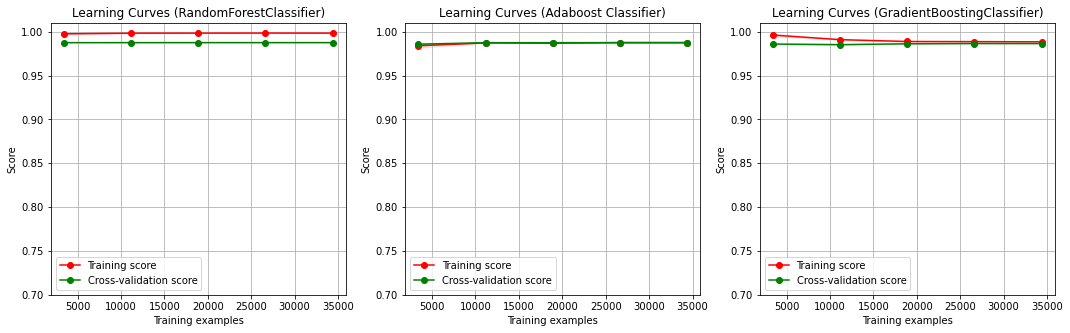

In [43]:
import plot_learning_curve as plt_lc

fig, axes = plt.subplots(1, 3,figsize=(18, 5),squeeze=False)

X, y = X_train, y_train

title = "Learning Curves (RandomForestClassifier)"
estimator = RandomForestClassifier()
plt_lc.plot_learning_curve(estimator, title, X, y, axes=axes[:,0], ylim=(0.7, 1.01),
                    cv=None, n_jobs=-1)

title = "Learning Curves (Adaboost Classifier)"
estimator = AdaBoostClassifier()
plt_lc.plot_learning_curve(estimator, title, X, y, axes=axes[:,1], ylim=(0.7, 1.01),
                    cv=None, n_jobs=-1)

title = "Learning Curves (GradientBoostingClassifier)"
estimator = GradientBoostingClassifier()
plt_lc.plot_learning_curve(estimator, title, X, y, axes=axes[:,2], ylim=(0.7, 1.01),
                    cv=None, n_jobs=-1)

plt.show()

 I will select GradientBoostingClassifier as the optimal model and it will be used in GridSearch parametrization.

## Classifier parametrization

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
!cp ../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv Udacity_MAILOUT_052018_TEST.csv 